<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-для-обучения-моделей" data-toc-modified-id="Подготовка-для-обучения-моделей-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка для обучения моделей</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес-деревьев" data-toc-modified-id="Случайный-лес-деревьев-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Случайный лес деревьев</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [30]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
# изучим файл
proba = pd.read_csv('/Users/Varvara/Documents/dataset/taxi.csv')
proba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [3]:
# перед изменениями проверим данные на явные дубликаты
proba.duplicated().sum()

0

In [4]:
# запишем данные в переменную, изменив тип данных столбца datetime с object на datetime64
# установим индекс таблицы равным столбцу datetime 
data = pd.read_csv('/Users/Varvara/Documents/dataset/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
# проверим, отсортированы ли данные в хронологическом порядке
data.index.is_monotonic

True

In [6]:
# сделаем ресемплинг по 1 часу
data = data.resample('1H').sum()

## Анализ

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


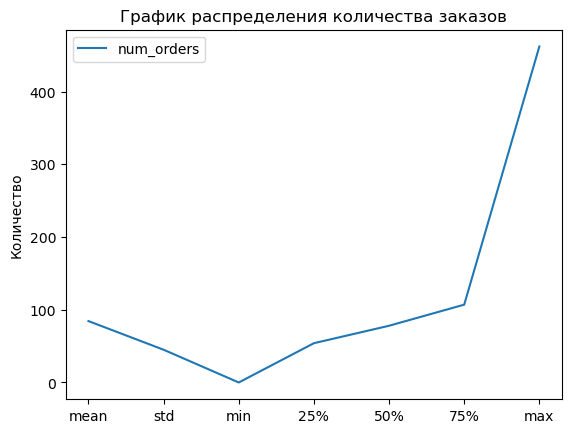

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [9]:
data.describe().drop(['count']).plot()
plt.title('График распределения количества заказов')
plt.ylabel('Количество')
plt.show()
data.describe()

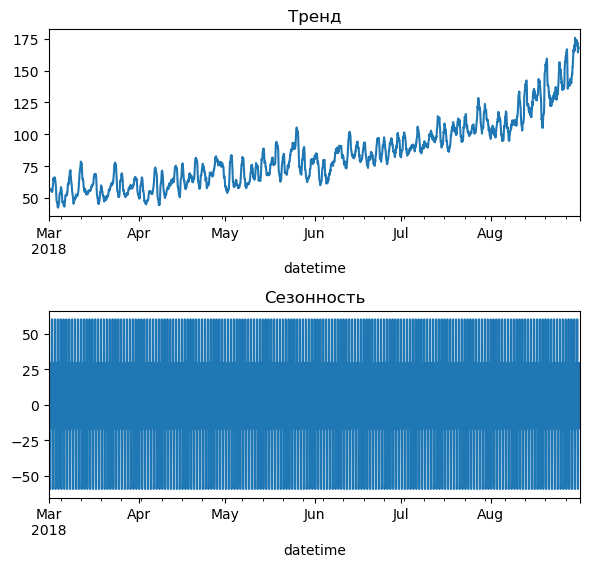

In [10]:
# изучим тренд и сезонность данных
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

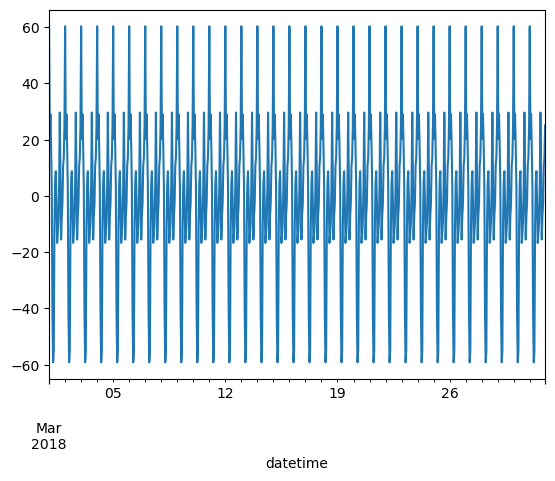

In [11]:
# проверим месячную сезонность
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

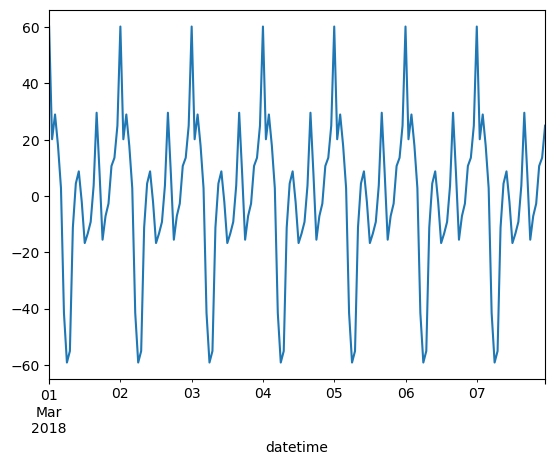

In [12]:
# проверим недельную сезонность
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())

**Выводы**

В исходной таблице данные со временем и количеством заказов такси. Таблица содержит 26496 строк и 2 столбца. Явных дубликатов и пропусков нет, столбцы названы в соответсвии с хорошим стилем. Данные осортированы в хорологическом порядке.

Было произведено объединение данных по времени с интервалом в один час. После объединения в таблице стало 4416 строк. В среднем за один час совершается около 84 заказов такси, однако бывает и ни одного заказа, а бывает 462.

В результате анализа динамики изменений количества заказов был выявлен несезонный тренд на рост количества вызываемых такси. Вероятно, у заказов есть сезонность, но для такого заключения недостаточно данных (необходимо собрать их за несколько лет). Данные поддаются описанию стационарным стохаическим процессом, по ним можно делать прогнозы.

## Обучение

### Подготовка для обучения моделей

In [13]:
# напишем функцию, которая добавит в таблицу признаков
def make_features(data, max_lag, rolling_mean_size):
    data_n = data.copy()
    
    data_n['month'] = data_n.index.month
    data_n['day'] = data_n.index.day
    data_n['dayofweek'] = data_n.index.dayofweek
    data_n['hour'] = data_n.index.hour
    
    for lag in range(1, max_lag + 1):
        data_n['lag_{}'.format(lag)] = data_n['num_orders'].shift(lag)

    data_n['rolling_mean'] = data_n['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_n

In [14]:
# добавим признаков 
data = make_features(data, 3, 1)

In [15]:
# разделим данные на обучающую, валидационную и тестовую выборки
# для тестовой выборки выделим 10% данных, для валидационной - 20%:
train_f, valid = train_test_split(data, shuffle=False, test_size=0.2, train_size=0.8)
train, test = train_test_split(train_f, shuffle=False, test_size=0.125, train_size=0.875)

print('Обучающая выборка содержит', train.shape[0], 'строк')
print('Валидационная выборка содержит', valid.shape[0], 'строк')
print('Тестовая выборка содержит', test.shape[0], 'строк')

Обучающая выборка содержит 3090 строк
Валидационная выборка содержит 884 строк
Тестовая выборка содержит 442 строк


In [16]:
# после добавления новых признаков из-за отстающих значений появились пропуски, удалим их
train = train.dropna()

In [17]:
# подготовим признаки
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Обучение моделей

In [18]:
# назначим новую метрику scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [19]:
# подготовим разделитель для выборок по времени при кросс-валидации
tscv = TimeSeriesSplit(n_splits=5)

####  Линейная регрессия

In [20]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train) 
pred_lr = model_lr.predict(features_valid)
rmse = mean_squared_error(target_valid, pred_lr)**0.5

print('RMSE линейной регрессии:', rmse.round(1))

RMSE линейной регрессии: 47.7


####  Случайный лес деревьев

In [22]:
# подберем параметры для леса через GridSearchCV
model_rf = RandomForestRegressor()
param_grid = {'max_depth' : range(1,31),
              'n_estimators' : range(1,26)} 
grid = GridSearchCV(estimator=model_rf, param_grid=param_grid, scoring=scorer, cv=tscv)
grid.fit(features_train, target_train)
best_params = grid.best_params_
best_params

{'max_depth': 11, 'n_estimators': 24}

In [24]:
pred_rf = grid.predict(features_valid)
rmse = mean_squared_error(target_valid, pred_rf)**0.5

print('RMSE случайного леса:', rmse.round(1))

RMSE случайного леса: 49.3


#### CatBoost

In [26]:
# подберем параметры для CatBoost через GridSearchCV
cat = CatBoostRegressor()
params = {'iterations': range(200, 700, 50),
          'depth': range(1, 11),
          'learning_rate': [0.01, 0.03, 0.01]}

cat_grid = GridSearchCV(estimator=cat, param_grid=params, scoring=scorer, cv=tscv)
cat_grid.fit(features_train, target_train, verbose=0)
best_param = cat_grid.best_params_
best_param

{'depth': 5, 'iterations': 650, 'learning_rate': 0.03}

In [27]:
pred_cb = cat_grid.predict(features_valid)
rmse = mean_squared_error(target_valid, pred_cb)**0.5

print('RMSE CatBoost:', rmse.round(1))

RMSE CatBoost: 49.0


#### LightGBM

In [28]:
# подберем параметры для LightGBM через GridSearchCV
light = LGBMRegressor()
param_grid = {'n_estimators': range(100, 400, 50), 
              'max_depth': range(1,11),
              'verbose': [-1],
             'num_threads':[1]}

light_grid = GridSearchCV(light, param_grid, scoring=scorer, cv=tscv)

light_grid.fit(features_train, target_train)
best_param = light_grid.best_params_
best_param

{'max_depth': 4, 'n_estimators': 100, 'num_threads': 1, 'verbose': -1}

In [29]:
pred_l = cat_grid.predict(features_valid)
rmse = mean_squared_error(target_valid, pred_l)**0.5

print('RMSE LightGBM:', rmse.round(1))

RMSE LightGBM: 49.0


**Выводы**

В данном разделе было произведено разделение общей выборки на обучающую, валидационную и тестовую. Для решения задачи регрессии обучены 4 модели. Две с градиентым бустингом: LightGBM и CatBoost. Две обычные: случайный лес деревьев и линейная регрессия. 

Наименьшее значение метрики RMSE у линейной регрессии: 47.7. На втором месте две модели CatBoost и LightGBM - с показателями RMSE 49.0. Наибольшее значение RMSE у случайного леса - 49.3.

## Тестирование

Так как наименьшее значение метрики RMSE у линейной регрессии, выберем данную модель. Проверим ее на тестовой выборке:

In [31]:
model_best = LinearRegression()
model_best.fit(features_train, target_train) 
pred_test = model_best.predict(features_test)
rmse = mean_squared_error(target_test, pred_test)**0.5

print('RMSE лучшей модели:', rmse.round(1))

RMSE лучшей модели: 34.8


In [ ]:
#дообучим выбранную модель на тренировочной+валидационной выборке для улучшения результата и проверим ее показатели на тестовой
#train_valid = pd.concat([valid, train])
#features_train_valid = train_valid.drop(['num_orders'], axis=1)
#target_train_valid = train_valid['num_orders']

#model_best_d = LinearRegression()
#model_best_d.fit(features_train, target_train) 
#pred = model_best_d.predict(features_test)
#rmse = mean_squared_error(target_test, pred)**0.5

#print('RMSE лучшей дообученной модели:', rmse.round(1))

# в результате RMSE неизменилась, так что я закомментировала эту часть

In [33]:
# проверим модель на адекватность, сравнив с константной моделью
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
rmse = mean_squared_error(target_test, dummy_model.predict(features_test))**0.5

print('RMSE модели-болванки:', rmse.round(1))

RMSE модели-болванки: 105.3


In [42]:
#визуализируем сравнение результатов модели
#pd.DataFrame(np.array([model_lr.predict(features_valid), target_valid]).T, 
#        columns=['model', 'fact'], index=target_valid.index).plot(figsize=(9,4),
#                                                                  title = 'Preds vs FactTest',
#                                                                  ylabel = 'Num_Orders',
#                                                                  xlabel = 'Date');

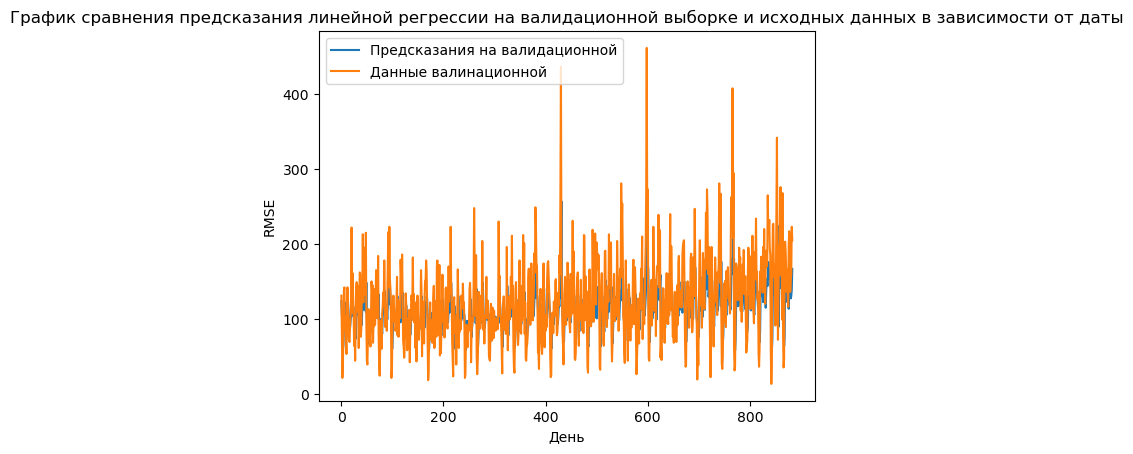

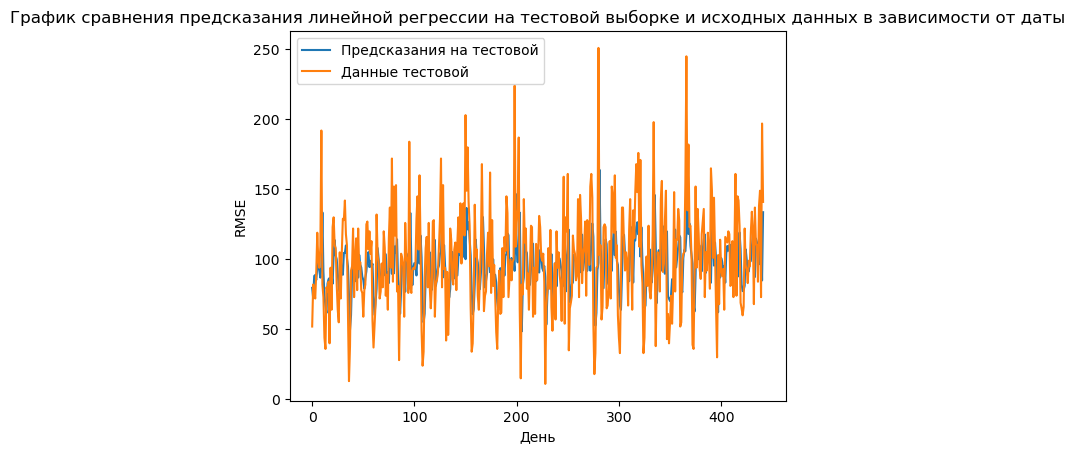

In [41]:
values = list(range(len(target_valid)))

plt.plot(values, pred_lr, label='Предсказания на валидационной')
plt.plot(values, target_valid, label='Данные валинационной')
plt.title('График сравнения предсказания линейной регрессии на валидационной выборке и исходных данных в зависимости от даты')
plt.ylabel('RMSE')
plt.xlabel('День')
plt.legend()
plt.show()

values = list(range(len(target_test)))

plt.plot(values, pred_test, label='Предсказания на тестовой')
plt.plot(values, target_test, label='Данные тестовой')
plt.title('График сравнения предсказания линейной регрессии на тестовой выборке и исходных данных в зависимости от даты')
plt.ylabel('RMSE')
plt.xlabel('День')
plt.legend()
plt.show()

## Общий вывод

В исходной таблице данные со временем и количеством заказов такси. Таблица содержит 26496 строк и 2 столбца. Явных дубликатов и пропусков нет, столбцы названы в соответсвии с хорошим стилем. Данные осортированы в хорологическом порядке.

Было произведено объединение данных по времени с интервалом в один час. После объединения в таблице стало 4416 строк. В среднем за один час совершается около 84 заказов такси, однако бывает и ни одного заказа, а бывает 462.

В результате анализа динамики изменений количества заказов был выявлен несезонный тренд на рост количества вызываемых такси. Вероятно, у заказов есть сезонность, но для такого заключения недостаточно данных (необходимо собрать их за несколько лет). Данные поддаются описанию стационарным стохаическим процессом, по ним можно делать прогнозы.

В данном разделе было произведено разделение общей выборки на обучающую, валидационную и тестовую. Для решения задачи регрессии обучены 4 модели. Две с градиентым бустингом: LightGBM и CatBoost. Две обычные: случайный лес деревьев и линейная регрессия. 

Наименьшее значение метрики RMSE у линейной регрессии: 47.7. На втором месте две модели CatBoost и LightGBM - с показателями RMSE 49.0. Наибольшее значение RMSE у случайного леса - 49.3.

Наилучшей моделью стала линейная регрессия. При проверке на тестовой выборке она показала отличный результат - RMSE 34.8. Также она прошла проверку на адекватность, модель-болванка показала RMSE в 3 раза выше. Данная модель отлично подходит для прогноза количества заказов такси на следующий час.